![alt text](https://raw.githubusercontent.com/louweal/wordgame/master/reports/figures/music_wordcloud.png "Word Association Analysis")

# Word Association Analysis

    Anneloes Louwe 
    https://www.github.com/louweal

## Introduction
In this notebook we analyse word associations from online word association games. The word association game is a game frequently played on internet forums. In this game, each player posts a word that was his (first) association for the word in the previous post (e.g. user1 writes 'green', user2 posts 'grass', user3 posts 'tree' and so on). 

We analyse these word associations to obtain new insights into structure of the mental lexicon and simply because it is fun to analyse this type of data. ;)

## Dataset
We collected this data in 2017 using ScraPy (web scraping) from multiple sources. All data was shuffled and anonymized. 

The dataset contains the following five columns:
- _author_ : an numeric identifier for each user
- _word1_ : the cue
- _word2_ : the association
- _source_ : abbreviation of the source name 
- _sourceID_ : an numeric identifier for the source

In [294]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
df = pd.read_csv('../data/processed/wordgame_20180814.csv') 
pal = sns.color_palette("Paired", 10) # color palette
df.sample(5, random_state=24)

,author,word1,word2,source,sourceID
149754,1904,wrap,=),GOG,4
179038,6135,messy.,Glitter,WP,9
262545,39,clerk,Customer,AC,0
190642,3192,Indiana,Hoosier,SAS,6
223330,1118,fix,patch,GOG,4


The number of word associations in this dataset:

In [8]:
len(df)

342267

The word associations are scraped from the following sources:
- AC : AspiesCentral (https://www.autismforums.com/forums/)
- BC : BleepingComputer (https://www.bleepingcomputer.com/forums/)
- CC : ClassicComics (https://classiccomics.org/)
- ECF : E-CigaretteForum (https://www.e-cigarette-forum.com/)
- GOG : Online game store (https://www.gog.com/forum)
- LEF : Learn English Forum (https://learnenglish.vanillacommunity.com) 
- SAS : Social Anxiety Support (https://www.socialanxietysupport.com/forum/)
- TF : The Fishy (https://forum.thefishy.co.uk/) 
- U2 : @U2 Forum (https://forum.atu2.com/)
- WP : Wrong Planet (https://wrongplanet.net/forums/)

Most data is (American) English and includes post from people from many different countries. LEF is a forum for people who want to learn English and therefore word associations from this source could contain more mistakes. Data from TF contains British English, since this is a forum for British football supporters. AC and WP are internet forums for people with autism, which might also effect the type of word associations. 

Number of word association from each source:

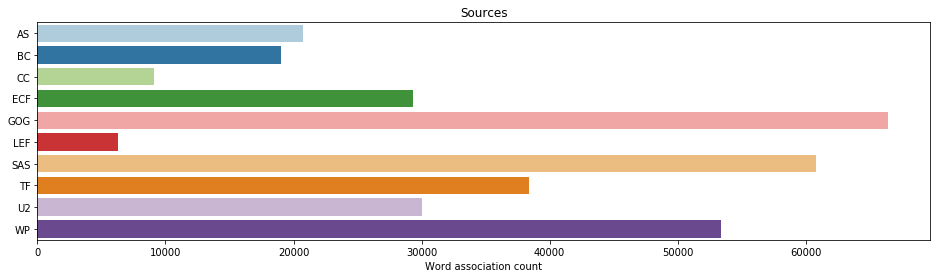

In [293]:
sources_names = ["AS", "BC", "CC","ECF","GOG","LEF","SAS","TF","U2","WP"] 
plt.figure(figsize=(16, 4))
sns.barplot(df.source.value_counts().sort_index(), sources_names, orient="h", palette=pal)
plt.title("Sources")
plt.xlabel('Word association count')
plt.show()

Number of unique users:

In [26]:
len(df.author.unique())

6386

Distribution of word association count per user:

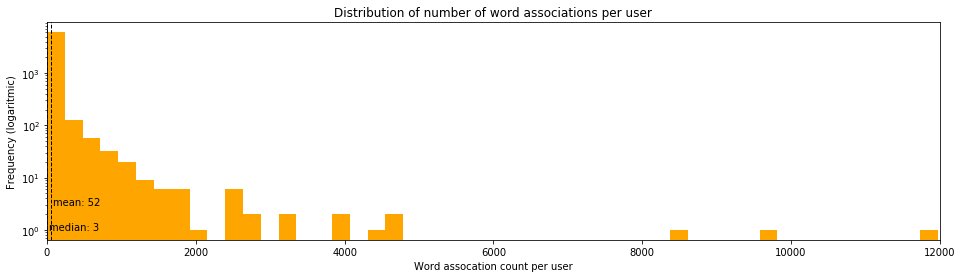

In [334]:
plt.figure(figsize=(16, 4))
median_wa = df.author.value_counts().median()
mean_wa = df.author.value_counts().mean()
plt.axvline(median_wa, color='k', linestyle='dashed', linewidth=1)
plt.text(median_wa+30, 1, "median: "+str(int(median_wa)))
plt.axvline(mean_wa, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_wa+30, 3, "mean: "+str(int(mean_wa)))
g= plt.hist(df.author.value_counts(), bins=50, color="orange")
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Distribution of number of word associations per user')
plt.xlabel('Word assocation count per user')
plt.ylabel('Frequency (logaritmic)')
plt.gca()
plt.xlim([1, 12000])
plt.show()

In [300]:
df.author.value_counts().mean()

52.69606448553817

The data is extremely skewed. Most players contribute only 3 word associations (median) to the game, but some authors are almost addicted to this game. One (severely addicted) person alone accounts for 3.6% of all data (12209 posts), whereas 54 posts per author would be optimal (mean).

## Methodology

In [22]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # data visualization
from collections import Counter

### Data cleaning

In [295]:
def preprocess(x):
    # replace
    x = x.replace('\n'," ") # (wrongplanet)
    x = x.replace("`", "'")
    x = x.replace("$$", "$") #allows $-signs but not multiple

    #remove 
    for symbol in ["_","~","^","xd"]:
        x = x.replace(symbol, "")
        
    if(x.find("said:") > 1):  #classic comics: removes posts containing quotes
        return ''
    
    # remove everything following ...
    for symbol in ["quote:","sent from my","edited by","posted via",
                   "/","(",",","*","\u00a0","--","*",'"',".","!","?","=","[","{",":",";",">","<"]:
        x = x.split(symbol)[0]

    #remove leading characters
    for symbol in ["+","-","&","'"," "]:
        x = x.lstrip(symbol)

    #remove trailing characters
    for symbol in ["-m", "'", " ", '\u00a0']:
        x = x.rstrip(symbol)
    return x

df['word1'] = df['word1'].astype(str) # converts floats to strings
df['word2'] = df['word2'].astype(str)

# delete all words containing non-ascii characters
df['word1'] = df['word1'].apply(lambda x: bytes(x, 'utf-8').decode('ascii','ignore'))
df['word2'] = df['word2'].apply(lambda x: bytes(x, 'utf-8').decode('ascii','ignore'))

#convert all to lowercase
df['word1'] = df['word1'].apply(lambda x: x.lower())
df['word2'] = df['word2'].apply(lambda x: x.lower())

# clean data
df['word1'] = df['word1'].apply(lambda x: preprocess(x))
df['word2'] = df['word2'].apply(lambda x: preprocess(x))

df = df.replace('',np.NaN) # replace empty word with np.NaN

# drop all pairs containing NaN values
df = df.dropna(axis=0, how='any').reset_index(drop=True)

# cut off all data longer than 25 characters, since words are rarely longer 
df['word1'] = df['word1'].apply(lambda x: x[:25] if len(x)>25 else x)
df['word2'] = df['word2'].apply(lambda x: x[:25] if len(x)>25 else x)

# remove pairs with identical words
df = df[df.word1 != df.word2]

In [296]:
df.sample(5, random_state=24)

,author,word1,word2,source,sourceID
279266,1752,clandestine,condition,GOG,4
200204,1668,mouse,mickey,GOG,4
2171,748,department,store,CC,2
36164,1416,today,yesterday,GOG,4
44218,891,greet,introduce,ECF,3


In [297]:
## save cleaned/preprocessed data
df.to_csv("../data/processed/wordgame_20200515_pr.csv", sep=',', index=False)

### Word frequency

Number of unique words:

In [301]:
len(df.drop_duplicates(['word2']))

60917

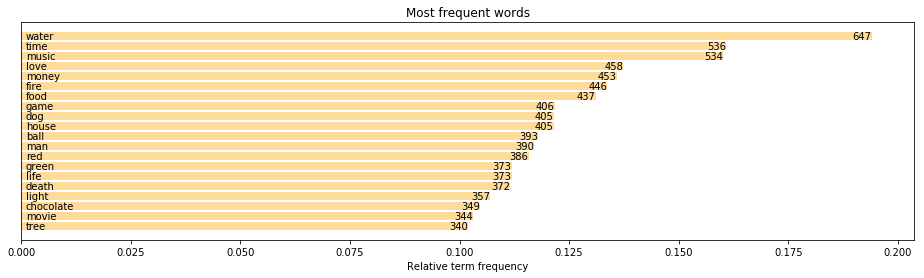

In [287]:
# compute term frequency (TF) feature
num_terms = len(df)
df['tf'] = df.groupby(['word2'])['word2'].transform('count')
df['rtf'] = df.tf.apply(lambda x: x*100/num_terms) # relative term frequency (percentage!)
frequent_words = df.drop_duplicates(subset=['word2']).sort_values(by=['tf'], ascending=False).head(20)
frequent_words = frequent_words[::-1] # reverse 

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_words.word2, frequent_words.rtf, color="orange", alpha=0.4)
for i in range(0,len(frequent_words)):
    ax.text(frequent_words.rtf.iloc[i], i, frequent_words.tf.iloc[i], ha='right', va='center')
    ax.text(0.001, i, frequent_words.word2.iloc[i], ha='left', va='center') 
ax.set_yticks([])
plt.title("Most frequent words")
plt.xlabel('Relative term frequency')
plt.ylabel('')
plt.show()

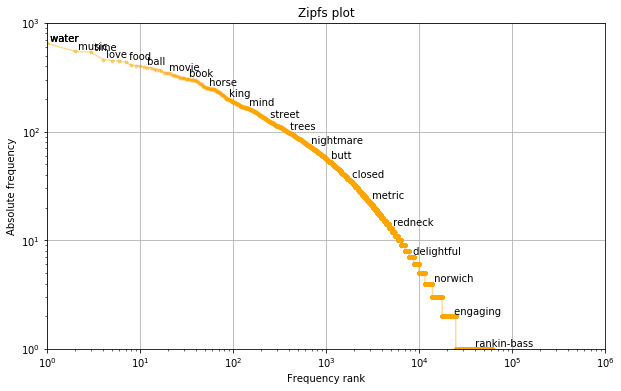

In [312]:
counts = np.array(df.word1.value_counts())
tokens = np.array(df.word1.value_counts().index)
ranks = np.arange(1, len(counts)+1)
indices = np.argsort(-counts)
frequencies = counts[indices]

plt.figure(figsize=(10, 6))
#plt.plot([1, 10e2], [10e2, 1], color='grey', linestyle='--', linewidth=1) # adds a diagonal line to the plot
plt.loglog(ranks, frequencies, marker=".", alpha=0.4, c="orange")
for n in list(np.logspace(-0.5, np.log10(len(counts)), 25).astype(int))[:-1]:
    dummy = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]], verticalalignment="bottom", 
                     horizontalalignment="left")
plt.title("Zipfs plot")
plt.xlabel("Frequency rank")
plt.ylabel("Absolute frequency")
plt.xlim(1, 10e5)
plt.ylim(1, 10e2)
plt.grid(True)
plt.show()

According to Zipfs law, the frequency of any word (in a large sample of words) is inversely
proportional to its rank in the frequency. It seems that the law does not apply for word association data.

### Word association frequency

In [356]:
df['pair'] = df.apply(lambda x: str(x.word1) + ":" + str(x.word2), axis=1)
df['pf'] = df.groupby(['pair'])['pair'].transform('count')
df['rpf'] = df.pf.apply(lambda x: x*100/num_terms) # 

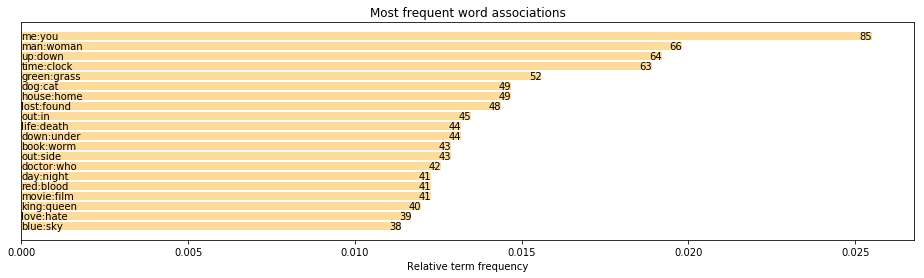

In [286]:
frequent_pairs = df.drop_duplicates(subset=['pair']).sort_values(by=['pf'], ascending=False).head(20)
frequent_pairs = frequent_pairs[::-1]

fig, ax = plt.subplots(figsize=(16, 4))
ax.clear()
ax.barh(frequent_pairs.word2, frequent_pairs.rpf, color="orange", alpha=0.4)
for i in range(0,len(frequent_pairs)):
    ax.text(frequent_pairs.rpf.iloc[i], i, frequent_pairs.pf.iloc[i], ha='right', va='center')
    ax.text(0, i, frequent_pairs.pair.iloc[i], ha='left', va='center') 
ax.set_yticks([])
plt.title("Most frequent word associations")
plt.xlabel('Relative term frequency')
plt.ylabel('')
plt.show()

## Feature Extraction

### Syntactic Features
#### Word length

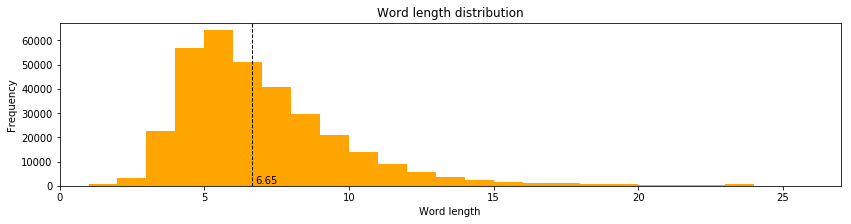

In [318]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
df['ldiff'] = abs(df['len1'] - df['len2']) # length difference between word1 and word2 

plt.figure(figsize=(14, 3))
f = plt.hist(df.len2, bins=np.arange(0,25), color='orange') 
plt.axvline(df.len2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(df.len2.mean()+0.1, 1000, str(round(df.len2.mean(),2)))
plt.title('Word length distribution')
plt.xlabel('Word length')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_xlim([0,27])
plt.show()

### Common affixes
Word association can be either semantical (e.g. 'blue' -> 'sky') or syntactic (e.g. 'bowels' -> 'vowels'). Here we find the common prefixes and suffixes (e.g. the suffix is 'owels' in the previous example) and the length of these common affixes.

In [319]:
import os
# find common prefix
df['prefix'] = df.apply(lambda r: os.path.commonprefix([r.word1, r.word2]), axis=1)
df['pl']= (df['prefix'].apply(lambda x: len(x))) # compute common prefix length

# find common suffix
df['suffix'] = df.apply(lambda r: os.path.commonprefix([r.word1[::-1], r.word2[::-1]]), axis=1)
df['suffix'] = df['suffix'].apply(lambda x:x[::-1]) #un-reverse suffix
df['sl']= (df['suffix'].apply(lambda x: len(x))) # compute common affix length

In [18]:
print("Most frequent common prefices: " + str(list(df.prefix.value_counts().head(10).index)))
print("Most frequent common suffices: " + str(list(df.suffix.value_counts().head(10).index)))

Most frequent common prefices: ['', 's', 'c', 'b', 'p', 'm', 'f', 't', 'd', 'a']
Most frequent common suffices: ['', 'e', 's', 't', 'y', 'n', 'ed', 'er', 'ing', 'r']


make two subplots: left prefixes and right affixes? 

In [321]:
df.prefix.value_counts().head(20)

      296474
s       4877
c       2771
b       2315
p       1966
m       1244
f       1190
t       1123
d       1072
a        927
w        662
h        657
r        629
g        559
l        531
e        483
re       446
co       383
n        257
i        240
Name: prefix, dtype: int64

### Levenstein Distance

Levenshtein distance (also called Edit Distance) is a measure of the similarity between two strings. It is minimum the number of deletions, insertions, or substitutions required to transform the first string into the second.

In [336]:
import Levenshtein
df['edit'] = df.apply(lambda r:Levenshtein.distance(r.word1, r.word2), axis=1)

In [342]:
df['norm_edit'] = df.apply(lambda r:r.edit/max(r.len1,r.len2), axis=1) # rough normalization of edit distances

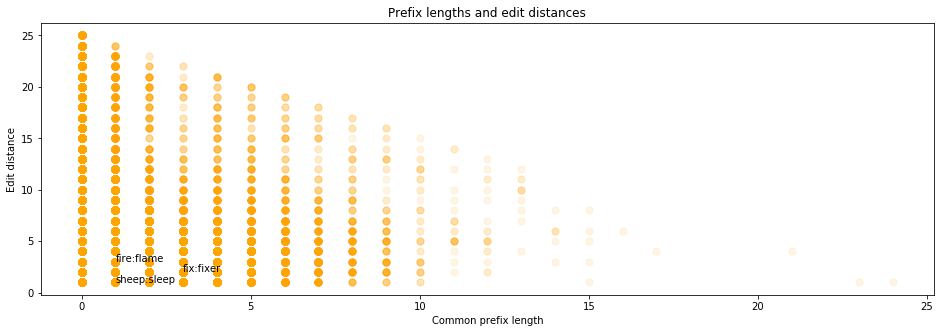

In [388]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(df.pl, df.edit, alpha=0.1, s=50, c="orange")
for i in range(2, len(df), 5000):
    if df.pl.iloc[i] > 0 and df.edit.iloc[i] < 6:
        ax.annotate(df.pair.iloc[i], (df.pl.iloc[i], df.edit.iloc[i]))
plt.title("Prefix lengths and edit distances")
plt.xlabel("Common prefix length")
plt.ylabel("Edit distance")
plt.show()

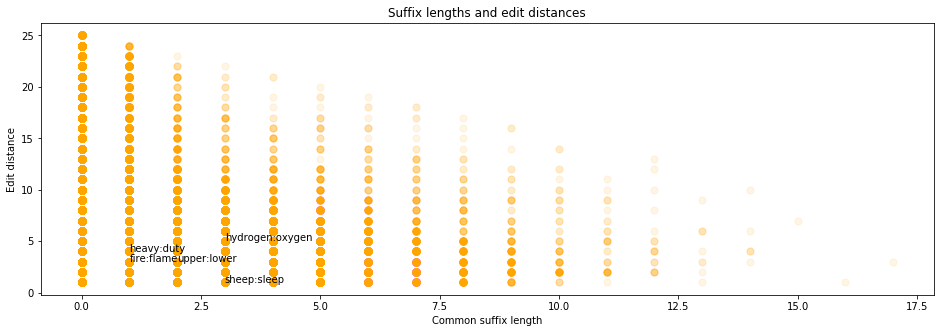

In [390]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(df.sl, df.edit, alpha=0.1, s=50, c="orange")
for i in range(2, len(df), 5000):
    if df.sl.iloc[i] > 0 and df.edit.iloc[i] < 6:
        ax.annotate(df.pair.iloc[i], (df.sl.iloc[i], df.edit.iloc[i]))
plt.title("Suffix lengths and edit distances")
plt.xlabel("Common suffix length")
plt.ylabel("Edit distance")
plt.show()

This concludes the syntactic feature extraction. In the next section we move on to the semantic features such as word similarity. :)

## Semantic Features
Here we extract features related to word meaning. We start with word embedding models.

### Word Embedding Model (Word2Vec)

In [396]:
# create the documents for model training
copydf = df.copy() # copy the data
copydf['word2'] = copydf.word2.apply(lambda x: [x]) 
clouddf = copydf.groupby(['word1']).agg({'word2':'sum'}).reset_index() # group by cue
 # add cue word also to word list, as many times as it has associations
clouddf['document'] = clouddf.apply(lambda r: [r.word1]*len(r.word2) + r['word2'], axis=1)
clouddf[['document']].sample(5, random_state=42) # show some examples

,document
26837,"[impulsive, impulsive, impulsive, impulsive, b..."
12160,"[coupe, coupe, coupe, hatchback, convertible, ..."
55092,"[too much can be a bad thi, just can't get eno..."
34967,"[mowgli, mowgli, mowgli, jungle, monkey, india]"
51842,"[supper-time, having]"


In [397]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# create W2V model
w2v_model = Word2Vec(clouddf.document, size=300, min_count=1, sg=1, workers=10)

In [398]:
# create word corpus
corpus = list((dict(Counter(df.word1.tolist()).most_common()).keys()))[::-1]

# add word vector to 4000 most frequent words (t-sne can't handle the full dataset)
corpusdf = pd.DataFrame(corpus[-4000::], columns=['word'])
corpusdf['wordvector'] = corpusdf.word.apply(lambda x: w2v_model.wv[x])

# Compute reduced word-vectors using t-sne
tsnemodel = TSNE(random_state=42).fit_transform(corpusdf['wordvector'].tolist()) 
corpusdf['x'] = tsnemodel[:,0]
corpusdf['y'] = tsnemodel[:,1]

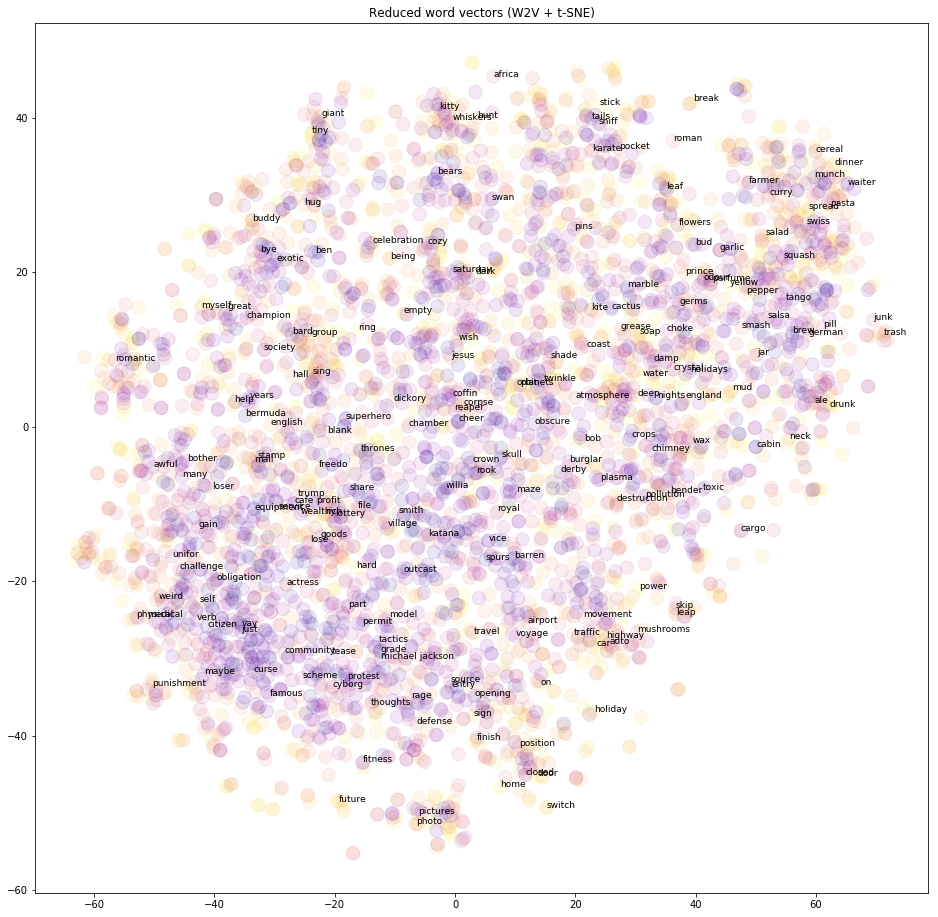

In [402]:
# plot 
corpusdf = corpusdf[::-1] # reverse
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(16)
sc = ax.scatter(corpusdf.y, corpusdf.x, marker='o', c=corpusdf.index, 
                cmap=plt.get_cmap('plasma'), s=180, alpha=0.1)
for j in range(0,4000,19): #len(corpusdf), 20):
    ax.annotate(corpusdf.word.iloc[j], (corpusdf.y.iloc[j], corpusdf.x.iloc[j]), fontsize='9')
plt.title("Reduced word vectors (W2V + t-SNE)")
plt.show()

In [403]:
df['sim'] = df.apply(lambda r:w2v_model.wv.similarity(r.word1, r.word2), axis=1)

/home/anneloes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


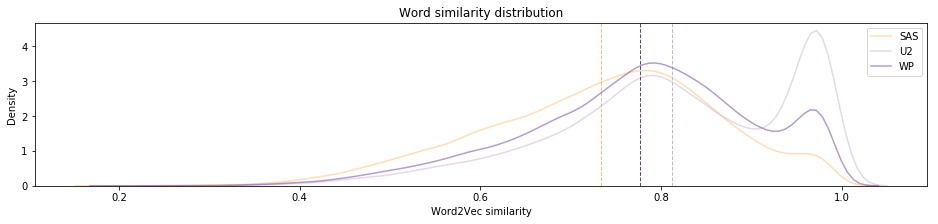

In [418]:
plt.figure(figsize=(16, 3))
for i in [6,8,9]:
    s = df[df['sourceID']==i]
    plt.axvline(s.sim.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s.sim, label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Word similarity distribution')
plt.xlabel("Word2Vec similarity")
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [436]:
df[['source','pair','sim']].drop_duplicates(subset=['pair']).sort_values(by=['sim'], ascending=False).head(5)

,source,pair,sim
244794,TF,comedy gold:fools + horses,0.997053
287548,AC,blowhard:boastful,0.997038
227896,GOG,mope:sulk,0.996908
1089,GOG,preeminent:distinguished,0.996790
116856,GOG,eskimos:igloos,0.996683


### Pre-trained Word Embedding model
Next make a more semantically meaningful word embedding, that is not influenced by the word frequencies in the dataset, by using a pre-trained model that is trained on different data. We use this pre-trained Google News corpus word vector model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit.

In [420]:
from gensim.models.keyedvectors import KeyedVectors
# this might take a while, and requires a computer with a decent amount of memory (16+ GB)
w2v_news_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)

Loaded word embeddings


In [422]:
df['word1w2v'] = df.word1.apply(lambda x:(x.replace(" ", "_"))) # the example -> the_example (word2vec convention)
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
#print(df[df.inw2v1==False].head(10).word1w2v.tolist())
print("Percentage of list in word2vec vocabulary (word1): " + str(round(df.inw2v1.sum()/len(df)*100,1)))

Percentage of list in word2vec vocabulary (word1):88.7


During data cleaning we converted all words to lowercase. However, word2vec is case sensitive. Therefore, we also apply title capitalization to the words that did not match the word2vec vocubulary and search for the word again. When this also does not return a vocabulary hit, we convert the word to uppercase and search once more. 

In [427]:
# apply title capitilization
df.loc[~df.inw2v1, 'word1w2v'] = df.loc[~df.inw2v1].word1w2v.apply(lambda x:x.title()) # the_example -> The_Example
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
# uppercase
df.loc[~df.inw2v1, 'word1w2v'] = df.loc[~df.inw2v1].word1w2v.apply(lambda x:x.upper())
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_news_model.vocab))
print("Percentage of list in word2vec vocabulary (word1): " + str(round(df.inw2v1.sum()/len(df)*100,1)))

Percentage of list in word2vec vocabulary (word1): 92.9


This approach resulted in an increase of 4% in vocabulary hits for word1. Below we also apply it to word2 and compute the number of pairs of which both words were found in the word2vec model. 

In [429]:
df['word2w2v'] = df.word2.apply(lambda x:(x.replace(" ", "_"))) 
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab)) 
df.loc[~df.inw2v2, 'word2w2v'] = df.loc[~df.inw2v2].word2.apply(lambda x:x.title())
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab))
df.loc[~df.inw2v2, 'word2w2v'] = df.loc[~df.inw2v2].word2.apply(lambda x:x.upper())
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_news_model.vocab))

df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
df = df.drop('inw2v1', 1)
df = df.drop('inw2v2', 1)

print("Percentage of pairs found word2vec vocabulary (word1 AND word2): " + str(round(df.inw2v.sum()/len(df)*100,1)))

Percentage of pairs found word2vec vocabulary (word1 AND word2): 86.3


I think that's not a bad result given the highly informal nature of the word association games. 

In [431]:
df['news_sim'] = np.nan # similarity for unknown word pairs
df.loc[df.inw2v, 'news_sim'] = df.loc[df.inw2v].apply(lambda r:w2v_news_model.similarity(r.word1w2v, r.word2w2v), axis=1)

I'll show you some word pairs with highly similar words (according to Google) below. 

In [434]:
df[['pair','news_sim']].drop_duplicates(subset=['pair']).sort_values(by=['news_sim'], ascending=False).head(5)

,pair,news_sim
207715,four:three,0.970343
39303,three:four,0.970343
22224,south:north,0.967454
2487,north:south,0.967454
38204,west:east,0.965322


And a plot of the similarity distributions... 

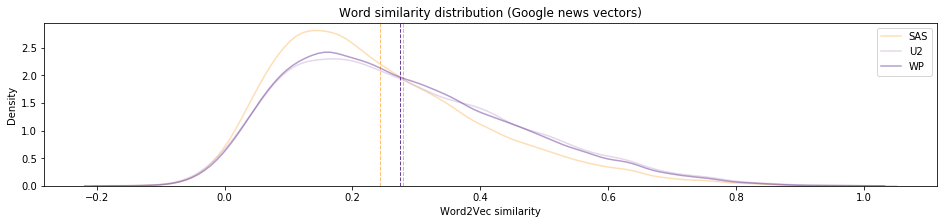

In [443]:
w2vdf = df[df.inw2v==True] # only keep pairs with similarity scores

plt.figure(figsize=(16, 3))
for i in [6,8,9]: #[3,7]: #range(0,10): #[6,8,9]:
    s = w2vdf[w2vdf['sourceID']==i]
    plt.axvline(s.news_sim.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s.news_sim, label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Word similarity distribution (Google news vectors)')
plt.xlabel("Word2Vec similarity")
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

In [444]:
from sklearn.manifold import TSNE

sampleA = w2vdf[(w2vdf['word1w2v'].isin(["death","life"]))][:] # select only pairs with word1=life||death
sampleA['wv2'] = sampleA['word2w2v'].apply(lambda x: w2v_news_model.word_vec(x)) # compute word vector
sampleA['c'] = sampleA.groupby(['word2w2v'])['word2w2v'].transform('count') # count duplicate pairs

#del w2v_news_model # free some memory

model = TSNE(random_state=42).fit_transform(sampleA['wv2'].tolist()) # Compute reduced word-vectors
sampleA['x'] = model[:,0]
sampleA['y'] = model[:,1]

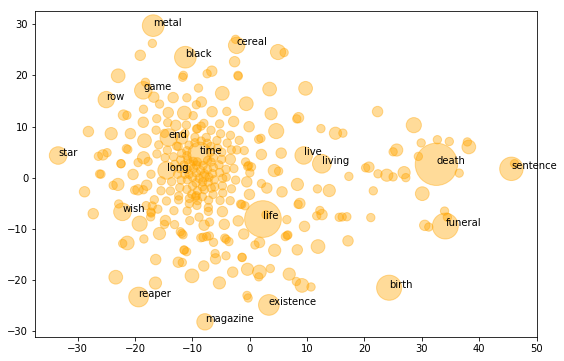

In [447]:
sampleA = sampleA.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(6)
ax.scatter(sampleA.y, sampleA.x, marker='o', s=30+40*sampleA.c, alpha=0.4, color="orange")
for j in range(0,len(sampleA)):
    if(sampleA.c.iloc[j] > 5):
        ax.annotate(sampleA.word2.iloc[j], (sampleA.y.iloc[j], sampleA.x.iloc[j]))
plt.show()

In [448]:
sampleB = w2vdf[(w2vdf['word1w2v'].isin(["food","chocolate"]))][:] # select only pairs with word1=food||chocolate
sampleB['wv2'] = sampleB['word2w2v'].apply(lambda x: w2v_news_model.word_vec(x)) # compute word vector
sampleB['c'] = sampleB.groupby(['word2w2v'])['word2w2v'].transform('count') # count duplicate pairs

model = TSNE(random_state=24).fit_transform(sampleB['wv2'].tolist()) # Compute reduced word-vectors
sampleB['x'] = model[:,0]
sampleB['y'] = model[:,1]

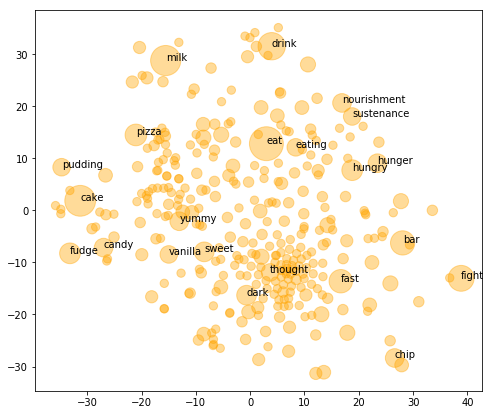

In [451]:
sampleB = sampleB.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(7)
ax.scatter(sampleB.x, sampleB.y, marker='o', s=30+40*sampleB.c, alpha=0.4, color="orange")
for j in range(0,len(sampleB)):
    if(sampleB.c.iloc[j] > 5):
        ax.annotate(sampleB.word2.iloc[j], (sampleB.x.iloc[j], sampleB.y.iloc[j]))
plt.show()

### WordNet / NLTK
Besides Word2Vec there exist many other sources that can provide semantic information about words. An important source is WordNet, which is a lexical database for the English language, which was created by Princeton, and is part of the NLTK corpus. It can be used to classify words as nouns, verbs and more. Word pairs can be identified as synonyms, antonyms, hypernyms and hyponyms. 

In the code below we create (boolean) features for nouns, synonyms, antonyms, hypernyms and hypernyms (or at least that's what I attempted to do because I did not fully understand the ntlk.corpus package).

In [54]:
from itertools import chain
from nltk.corpus import wordnet

nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')} 
df['noun'] = df['word2'].apply(lambda x:(x in nouns)) 

In [55]:
def isSynonym(r):
    synonyms = wordnet.synsets(r.word1)
    lemmas = set(chain.from_iterable([w.lemma_names() for w in synonyms]))
    return (r.word2 in lemmas)

df['synonym'] = df.apply(isSynonym, axis=1)

In [56]:
def isAntonym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        for l in syn.lemmas():
            if l.antonyms():
                h.append(l.antonyms()[0].name().split('.')[0]) 
    return (r.word2 in h)

df['antonym'] = df.apply(isAntonym, axis=1)

Hyponymy shows the relationship between a generic term (hypernym) and a specific instance of it (hyponym).

In [57]:
def isHypernym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hypernyms():
            h.append(syn.hypernyms()[0].name().split('.')[0])
    return (r.word2 in h)
df['hypernym'] = df.apply(isHypernym, axis=1)

In [58]:
def isHyponym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hyponyms():
            h.append(syn.hyponyms()[0].name().split('.')[0]) 
    return (r.word2 in h)
df['hyponym'] = df.apply(isHyponym, axis=1)

In [65]:
dfsem = df[df.synonym | df.antonym | df.hypernym | df.hyponym]
print("Percentage of pairs with semantic relationship(s): " + str(round(len(dfsem)/len(df)*100,2)))
dfsem[['word1', 'word2', 'synonym', 'antonym', 'hypernym', 'hyponym']].head(5)

Percentage of pairs with semantic relationship(s): 6.76


,word1,word2,synonym,antonym,hypernym,hyponym
48,wound,hurt,True,False,True,False
80,grow,mature,True,False,False,False
84,hot,cold,False,True,False,False
111,resort,hotel,False,False,True,False
114,sweater,cardigan,False,False,False,True


Only a small percentage of the word pairs appear to have semantic relationships (or the WordNet did not return the correct results), but as can be expected synonyms are the most represented in the WAG data. 

## Psychological features
Last but not least we are going to enrich the data with some psychological and psycholinguistic features.

### Autism
We can assume that authors from AC and WP are more likely to have an autism spectrum disorder (ASD) and that authors from other sources are more likely not to have ASD (given that the current ASD prevalence estimate is < 2%). Still, it's a HUGE assumption to classify authors based on their presence in a specific online community, but I'm going to include this 'feature' anyways as it is the only additional information about the authors that we have. 

In [66]:
df['ASD'] = df['sourceID'].apply(lambda x:int((x%9)==0)) # 0= AspiesCentral, 9=WrongPlanet
print("Percentage of data from WP and AC: " + str(round(df.ASD.mean()*100,1)))

Percentage of data from WP and AC: 22.2


### Age-of-Acquisition
Age of Acquisition is a psycholinguistic variable referring to the age at which a word is typically learned. Source: http://crr.ugent.be/archives/806. 

In [55]:
import csv
reader = csv.reader(open('../data/external/AoA_ratings_Kuperman.csv', 'r'))

AoA = {} 
for k, v in reader: # read data from CSV in to python dictionary
    if(v != 'NA'):
       AoA[k] = v

df['AoA'] = df['word2'].apply(lambda x:float(AoA[x]) if x in AoA else np.nan) 
print("Percentage of words (word2) with known Age of Acquisition: " + str(round(len(df[~df['AoA'].isnull()])/len(df)*100,1)))
#print("List of words with unkonwn AoA: \n")
#df[df.AoA.isnull()].tail(20).word2.tolist()

Percentage of words (word2) with known Age of Acquisition: 71.9


In [59]:
df[['word2','AoA']].sample(5, random_state=24)

,word2,AoA
119539,safety,5.84
199978,burn,4.72
188279,brick,6.43
51321,stop,2.89
1614,music,3.81


In [73]:
len(plotdf)

18286

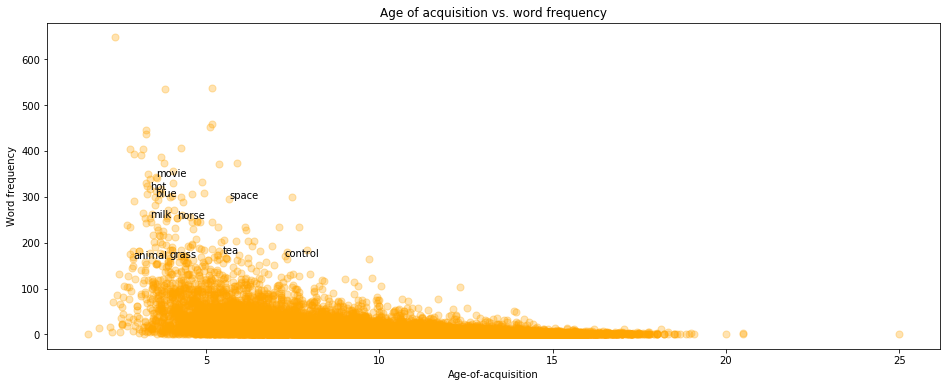

In [87]:
plotdf = df[df.AoA > 0]
plotdf = plotdf.drop_duplicates(['word2'])
# remove rows with nan aoa's
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(6)
ax.scatter(plotdf.AoA, plotdf.tf, alpha=0.3, s=50, c="orange")
for i in range(0, len(plotdf), 15):
    if plotdf.tf.iloc[i] > 150:
        ax.annotate(plotdf.word2.iloc[i], (plotdf.AoA.iloc[i], plotdf.tf.iloc[i]))
plt.title("Age of acquisition vs. word frequency")
plt.xlabel("Age-of-acquisition")
plt.ylabel("Word frequency")
plt.show()

For only (roughly) 70 percent of the data the age of acquisition could be determined. Stemming or singularization of plurals (e.g. shoes, legs...) can be considered to improve this result. 

The distribution of AoA scores for each source is plotted below. 

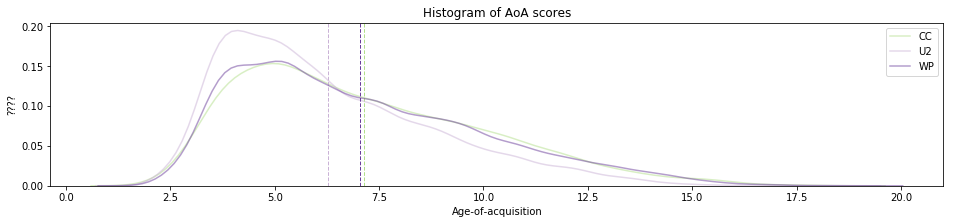

In [157]:
#aoadf = df[~df.AoA.isnull()] # only keep pairs with aoa scores
plotdf = df[df.AoA > 0]

plt.figure(figsize=(16, 3))
for i in [2,8,9]: #range(0,10,1):
    s = plotdf[plotdf['sourceID']==i]
    plt.axvline(s.AoA.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s['AoA'], label=s.iloc[0]['source'], alpha=0.5, color=pal[i])  
plt.title('Histogram of AoA scores')
plt.xlabel("Age-of-acquisition")
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.show()

U2-fans (U2) are frequently using words with really low AoA scores, which might indicate that their average age is also lower compared to other sources. The same might apply to the people with with social anxiety (SAS) and the Brittish football fans (TF). Gamers (GOG), for example, tend use words that are learnt later in life. The distribution also shows that overall most words are learnt around the age of 7. 

## Concreteness rating
Another phycholinguistic variable is the concreteness rating. (source: http://crr.ugent.be/archives/1330) 

In [193]:
reader = csv.reader(open('../data/external/Concreteness_english.csv', 'r'))
conc_dict = {k:v for k,v in reader if v!='NA'}
df['CR'] = df['word2'].apply(lambda x:conc_dict.get(x))
len(df[~df.CR.isnull()])/len(df)*100

74.91730667154481

Words like 'fire' have a high concreteness rating, whereas words like 'fail' and 'generic' have low concreteness ratings. 

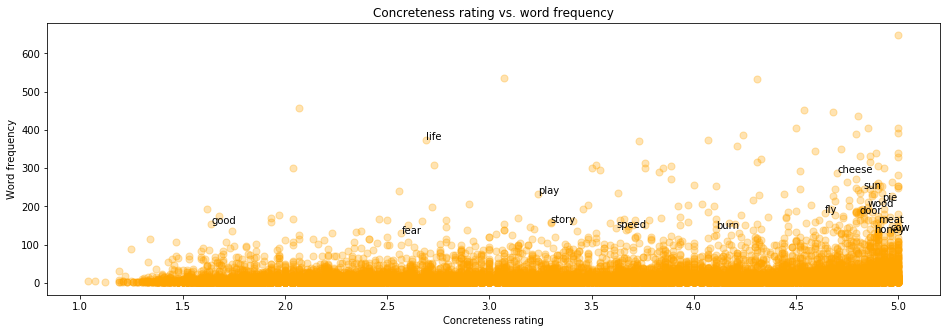

In [205]:
crdf = df[~df.CR.isnull()]
crdf.CR = crdf.CR.astype("float")
crdf = crdf.drop_duplicates(['word2'])

# remove rows with nan aoa's
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
ax.scatter(crdf.CR, crdf.tf, alpha=0.3, s=50, c="orange")
for i in range(0, len(crdf), 12):
    if crdf.tf.iloc[i] > 125:
        ax.annotate(crdf.word2.iloc[i], (crdf.CR.iloc[i], crdf.tf.iloc[i]))
plt.title("Concreteness rating vs. word frequency")
plt.xlabel("Concreteness rating")
#plt.xticks([1.0,5.0])
plt.ylabel("Word frequency")
plt.show()

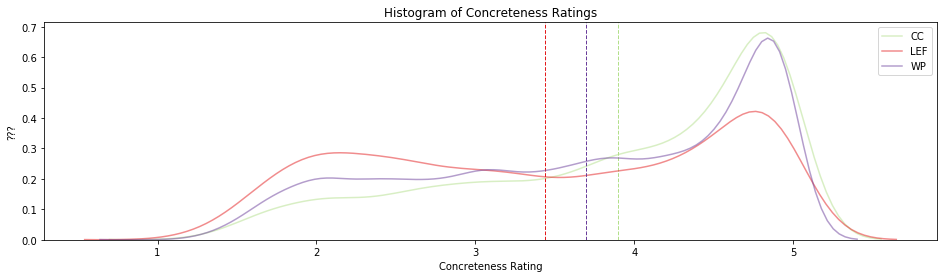

In [206]:
crdf = df[~df.CR.isnull()]
crdf.CR = crdf.CR.astype("float")

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(16, 4))
for i in [2,5,9]: #range(0,10,1):
    s = crdf[crdf['sourceID']==i]
    plt.axvline(s.CR.mean(), color=pal[i], linestyle='dashed', linewidth=1)
    sns.kdeplot(s['CR'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of Concreteness Ratings')
plt.xlabel('Concreteness Rating')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

Interestingly, non-native English speakers (LEF: Learn English Forum) most frequently use words with low concreteness ratings and least frequently use words with high concreteness. (compared to the other sources). The opposite is true for authors from TF (The Fishy, a football club from England).

This concludes the feature extraction phase. We extracted 10 syntactical features, 6 semantic features and 3 psychological/psycholinguistic features. In the next phase we are going discover some relationships between these features. 

In [ ]:
# save features
df.to_csv("../data/processed/wordgame_20180816_ft.csv", sep=',', index=False)

## Correlation
The Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. 

291602


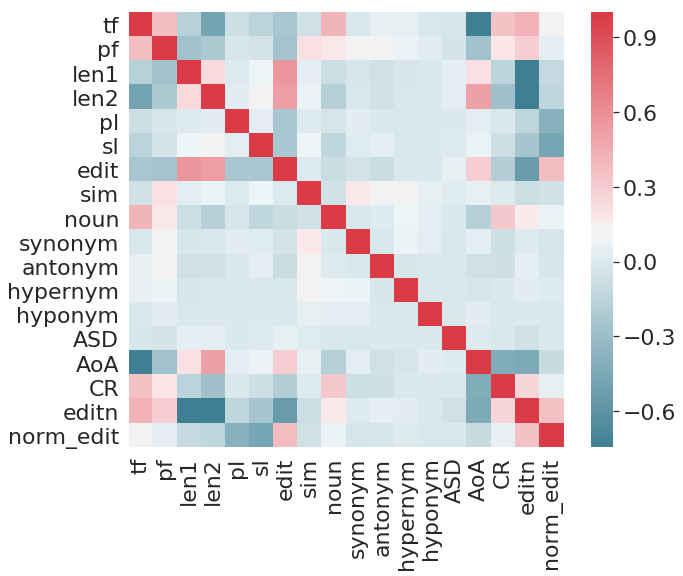

In [46]:
cordf = df
cordf = df[df.inw2v==True] # include only words pairs found in word2vec model
# removes columns for which we do not need correlation measures
cordf = cordf.drop('inw2v',1)
#cordf = cordf[~cordf.AoA.isnull()]
#cordf = cordf.drop('ASD',1)
cordf = cordf.drop('author',1)
#cordf = cordf.drop('len1',1)
cordf = cordf.drop('ldiff',1)
cordf = cordf.drop('sourceID',1)
print(len(cordf))

f, ax = plt.subplots(figsize=(10, 8))
corr = cordf.corr(method='spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

### Logistic Regression

In [ ]:
# todo

In [54]:
df[df.ASD==1].CR.mean()

3.7052219316270296

In [ ]:
# todo remove all 'phrases' approx. 14% of data? 

In [56]:
df.word1 = df.word1.astype(str)
df['multi'] = df.word1.apply(lambda x: x.find(" ")!=-1)
len(df[df.multi])/len(df)

0.07305779968931993

In [59]:
df.word2 = df.word2.astype(str)
df['multi'] = df.word2.apply(lambda x: x.find(" ")!=-1)
len(df[df.multi])/len(df)

0.07305779968931993

In [61]:
df[df.multi].sample(10)

,author,word1,word2,source,sourceID,tf,pair,pf,len1,len2,...,synonym,antonym,hypernym,hyponym,ASD,AoA,CR,editn,norm_edit,multi
136460,531,goodbyehello and goodbye,goodbyehello and goodbye,BC,1,8,goodbyehello and goodbye:adios,1,24,5,...,False,False,False,False,0,NaN,NaN,0.000475,0.875000,True
264316,4859,9 o'clock,9 o'clock,U2,8,254,9 o'clock:rock,1,9,4,...,False,False,False,False,0,3.22,4.91,0.003361,0.666667,True
1630,4886,mardi gras,mardi gras,U2,8,4,mardi gras:flashing,1,10,8,...,False,False,False,False,0,NaN,4.07,0.001219,0.800000,True
50955,4846,fried green tomatoes,fried green tomatoes,U2,8,1,fried green tomatoes:green apples,1,20,12,...,False,False,False,False,0,NaN,NaN,0.000183,0.600000,True
179671,4846,good morning vietnam,good morning vietnam,U2,8,1,good morning vietnam:from russia with love,1,20,21,...,False,False,False,False,0,NaN,NaN,0.000096,0.809524,True
265510,4719,hi cantgetenoughu2 - god so true - and i see b...,hi cantgetenoughu2 - god so true - and i see b...,U2,8,1,hi cantgetenoughu2 - god so true - and i see b...,1,65,15,...,False,False,False,False,0,NaN,NaN,0.000022,0.876923,True
154514,4725,it's a beautiful day,it's a beautiful day,U2,8,1,it's a beautiful day:don't let it get away,1,20,21,...,False,False,False,False,0,NaN,NaN,0.000091,0.761905,True
227324,538,jerry garcia,jerry garcia,BC,1,86,jerry garcia:ouch,1,12,4,...,False,False,False,False,0,2.42,2.76,0.002686,0.916667,True
118373,5782,lake champlain,lake champlain,WP,9,9,lake champlain:chocolates,1,14,10,...,False,False,False,False,1,NaN,NaN,0.000530,0.785714,True
81324,5020,cape cod,cape cod,WP,9,1,cape cod:cape canaveral,1,8,14,...,False,False,False,False,1,NaN,NaN,0.000546,0.571429,True


## Discussion
...

## Conclusion
...